# Performs untargeted peptide quantification of IDs from MSPLIT-DIA

In [199]:
from pyteomics import mgf
from pyteomics import mzxml
from pyteomics import mass

import pandas as pd
import numpy as np
import re
import pickle
import timeit
import time

import matplotlib.pyplot as plt
from pylab import rcParams

### Start by getting identifications from one MSPLIT-DIA search result
1. Read mzXML file from qualitative data collection and make dict of scan:CV pairs
2. Read MSPLIT-DIA search results file, sort peptides by cosine score, keep best score per peptide
3. Based on untargetd quant data collection, keep only doubly charged peptides, and peptides that end in R/K
4. Compute FDR rate by looping through the sorted peptides, return filtered dataframe w/o decoys
5. Read mzXML file from untargeted quant data collection make 

In [234]:
### makes a dict of scan:CV value pairs for lookup of the CV
tmp_cv_dict = {}
with mzxml.read("P:/JGM_DI2A/SILAC/20190411_DI2A_1to16_n1b.mzXML") as spectra:
    for x in spectra:
        tmp_cv_dict[x['num']] = x['compensationVoltage']

In [235]:
# read the search results and sort by cosine score
# read+sort by cosine
df = pd.read_csv("P:/JGM_DI2A/SILAC/2da10ppm_1to16_n1b.txt", sep="\t").sort_values('cosine', ascending=False)
# keep only the row that contains the best cosine score for a peptide
df = df.loc[df.groupby('Peptide').cosine.idxmax()].sort_values('cosine', ascending=False)

In [236]:
### keep only the rows where peptides were charge=2
df = df.loc[df['z.1']==2].reset_index()

In [237]:
# keep only the lines where peptide ended with 'K' or 'R'
endsrk = [df.loc[i] for i in range(0, len(df)) if np.any([df.loc[i]['Peptide'][-1:] =='R',df.loc[i]['Peptide'][-1:] =='K']) ]

In [238]:
# loop to compute the number of decoys and return the new df
fdrlevel = 0.01
fdr=0
sortedpepdf = pd.DataFrame(endsrk)
decoylines = [i for i, e in enumerate(sortedpepdf.Name.tolist()) if e == 'DECOY_null']
ndecoys = len(decoylines)
nlines=len(sortedpepdf)
lastdecoy = []

if(ndecoys==0):
    lastdecoy.append()
else:
    for i in range(0, ndecoys):
        fdr = (i+1)/decoylines[i]
        if(fdr>fdrlevel):
            lastdecoy.append(i)
if(len(lastdecoy)==0):  # handles when there are not enough decoy hits
    sortedpepdf = sortedpepdf.drop(sortedpepdf.index[decoylines])
    print('not enough decoy hits, accept all '+str(nlines-ndecoys)+' peptides @ FDR='+str(ndecoys/nlines))
    
# need to edit this from the R version
#if(len(lastdecoy)>=1 and (min(lastdecoy)-1) !=0):  ### handle when the FDR is achieved
    #i=min(lastdecoy)-1
    #fdr<-i/decoylines[i]
    #print(paste("fdr", round(length(decoylines[1:i])/decoylines[i], digits = 4)))
    #print("score cutoff")
    #print(t.first[decoylines[i],"cosine"])
    #print(paste("peptide hits=", decoylines[i]-i))
    #pep.output<-t.first[1:max(decoylines),]
    
if(len(lastdecoy)>=1 and (min(lastdecoy)-1) ==0): # handle when there are too many decoys
    print('FDR over '+str(fdrlevel))

not enough decoy hits, accept all 1634 peptides @ FDR=0.007893139040680024


In [239]:
# from filtered dataframe, take scan# and check what compensation voltage this uses and add to the dataframe
sortedpepdf['CV'] = [tmp_cv_dict[str(x)] for x in sortedpepdf['Scan#'].tolist()]

In [240]:
# get the FAIMS compensation voltages for the productive scan
# make dictionary with peptide sequence as key and list of [scan, cv] as value

sortedpepdf.head()

,index,#File,Scan#,Mz,z,Peptide,Mz.1,z.1,cosine,Name,...,stat11,stat12,stat13,stat14,stat15,stat16,stat17,stat18,stat19,CV
0,3112,P:\JGM_DI2A\SILAC\20190411_DI2A_1to16_n1b.mzXML,2420,420.0,2,APIIAVTR,420.77,2,0.976826,"human.faims.7197.7197. File:"""", NativeID:""scan...",...,34.0,82.0,21.0,0.0,0.936531,0.964773,2.925132,NaN,NaN,-70.0
1,166,P:\JGM_DI2A\SILAC\20190411_DI2A_1to16_n1b.mzXML,403,803.0,2,ALTGHLEEVVLALLK,803.48,2,0.973920,"human.faims.6092.6092. File:"""", NativeID:""scan...",...,8.0,13.0,4.0,0.0,0.979685,0.948266,0.161017,NaN,NaN,-30.0
2,123,P:\JGM_DI2A\SILAC\20190411_DI2A_1to16_n1b.mzXML,375,775.0,2,GTDVNVFNTILTTR,775.91,2,0.972525,"human.faims.41782.41782. File:"""", NativeID:""sc...",...,2.0,21.0,7.0,0.0,0.264671,0.970944,0.220307,NaN,NaN,-30.0
3,85,P:\JGM_DI2A\SILAC\20190411_DI2A_1to16_n1b.mzXML,333,733.0,2,S+42.01057DAAVDTSSEITTK,733.85,2,0.970295,"human.faims.106571.106571. File:"""", NativeID:""...",...,10.0,19.0,5.0,0.0,0.053764,0.772867,0.807127,NaN,NaN,-30.0
4,744,P:\JGM_DI2A\SILAC\20190411_DI2A_1to16_n1b.mzXML,785,585.0,2,ILLAELEQLK,585.36,2,0.970021,"human.faims.51242.51242. File:"""", NativeID:""sc...",...,16.0,51.0,4.0,0.0,0.177908,0.808319,0.036934,NaN,NaN,-40.0


In [241]:
### now open file for quant
# make dict the msx[1] isolation centers for each scan and the
precmzlist= []
mz_plus_cv_dict = {}

with mzxml.read("P:/JGM_DI2A/SILAC/20190412_DI2A_1to1_tMS2_n3.mzXML") as spectra:
    for x in spectra:
        tmpscannum = x['num']
        tmplightisolationcenter = x['precursorMz'][0]['precursorMz']
        tmpcv = x['compensationVoltage']
        precmzlist.append(tmplightisolationcenter)
        if str(tmplightisolationcenter)+','+str(tmpcv) not in mz_plus_cv_dict.keys():
            mz_plus_cv_dict[str(tmplightisolationcenter)+','+str(tmpcv)] = [int(tmpscannum)]
        else:
            mz_plus_cv_dict[str(tmplightisolationcenter)+','+str(tmpcv)].append(int(tmpscannum))

### Function to find the precursor isolation target closest to the peptide precursor mass

In [242]:
# make new column in dataframe that has the closest light ms1 isolation center
def find_nearest(array,value):
    idx = (np.abs(array-np.float_(value))).argmin()
    return array[idx]

# then use the function to add column to the dataframe
sortedpepdf['quantprecursor'] = [find_nearest(precmzlist, x) for x in sortedpepdf['Mz.1'].tolist()]

In [243]:
# get the quant scans using the dictionary with 'precmz,CV' keys
quantscans = []
for x in range(0, len(sortedpepdf)):
    quantscans.append(mz_plus_cv_dict[str(sortedpepdf['quantprecursor'].tolist()[x]) +',' +str(sortedpepdf['CV'].tolist()[x])])

In [244]:
sortedpepdf['quantscans'] = quantscans

In [245]:
len(sortedpepdf)

1634

# write filtered peptide ID file with the quantification coordinates for target quant files

### This file is also used to generate quantification target lists for data collection

In [15]:
#sortedpepdf.to_csv("P:/JGM_DI2A/SILAC/2da10ppm_1to16_n1b_sortedpepdf_withquant_rmnontry.txt", sep="\t")

# start here to read file with quant coordinates and skip above lines

In [246]:
sortedpepdf = pd.read_csv("P:/JGM_DI2A/SILAC/2da10ppm_1to16_n1b_sortedpepdf_withquant_rmnontry.txt", sep="\t",
                          converters={"quantscans": lambda x: x.strip("[]").split(", ")})

In [247]:
sortedpepdf.head()

,Unnamed: 0,index,#File,Scan#,Mz,z,Peptide,Mz.1,z.1,cosine,...,stat13,stat14,stat15,stat16,stat17,stat18,stat19,CV,quantprecursor,quantscans
0,0,3112,P:\JGM_DI2A\SILAC\20190411_DI2A_1to16_n1b.mzXML,2420,420.0,2,APIIAVTR,420.77,2,0.976826,...,21.0,0.0,0.936531,0.964773,2.925132,NaN,NaN,-70.0,420.5,"[1618, 4024]"
1,1,166,P:\JGM_DI2A\SILAC\20190411_DI2A_1to16_n1b.mzXML,403,803.0,2,ALTGHLEEVVLALLK,803.48,2,0.973920,...,4.0,0.0,0.979685,0.948266,0.161017,NaN,NaN,-30.0,803.0,"[269, 2675]"
2,2,123,P:\JGM_DI2A\SILAC\20190411_DI2A_1to16_n1b.mzXML,375,775.0,2,GTDVNVFNTILTTR,775.91,2,0.972525,...,7.0,0.0,0.264671,0.970944,0.220307,NaN,NaN,-30.0,776.0,"[251, 2657]"
3,3,85,P:\JGM_DI2A\SILAC\20190411_DI2A_1to16_n1b.mzXML,333,733.0,2,S+42.01057DAAVDTSSEITTK,733.85,2,0.970295,...,5.0,0.0,0.053764,0.772867,0.807127,NaN,NaN,-30.0,734.0,"[223, 2629]"
4,4,744,P:\JGM_DI2A\SILAC\20190411_DI2A_1to16_n1b.mzXML,785,585.0,2,ILLAELEQLK,585.36,2,0.970021,...,4.0,0.0,0.177908,0.808319,0.036934,NaN,NaN,-40.0,585.5,"[525, 2931]"


In [248]:
len(sortedpepdf)

1634

In [249]:
allpeptides = sortedpepdf['Peptide'].tolist()

### Function to get quantification fragments from sequence

In [263]:

# need function to get quant frags from peptide

def getQuantFrags(sequence, specname, libfileobj):
    '''
    PURPOSE: determine y-ion fragments to use for SILAC quantification
    
    INPUT:  1. string sequence of the peptide to fragment
            2. Spectra name
            3. spectral library file object
    
    OUTPUT: pandas dataframe of the sequence fragments and their light and heavy yion fragments
    '''
    
    hK=8.014199 ## mass of heavy lysine
    hR=10.00827 ## mass of heavy arg
    ### fix masses and get proton mass w/o electron
    customAAcomp = dict(mass.std_aa_comp)
    customAAcomp['C'] = mass.Composition({'H':8, 'C':5, 'S':1,'O':2, 'N': 2}) ## add carbamidomethyl to the modifications
    customAAcomp['m'] = mass.Composition({'H': 9, 'C': 5, 'S': 1, 'O': 2, 'N': 1}) ## add oxidized methionine
    protonmass = mass.calculate_mass(formula='H')-0.00054858 ## mass of hydrogen minus an electron
    # clean sequence to remove mod masses and change oxMet to 'm'
    sequence = re.sub('\+42.01057','', sequence)
    sequence = re.sub('\+57.0215','', sequence)
    sequence = re.sub('M\+15.9949','m', sequence)
    # clean sequence to remove mod masses and change oxMet to 'm'
    fraglist = []
    z=1
    for x in range(1, len(sequence)-1):
        fragseq = sequence[x:]
        lightfragmz = mass.calculate_mass(sequence=sequence[x:], ion_type='y', charge=1, aa_comp = customAAcomp)
        ## part to count the number of K and R residues
        nk = fragseq.count('K')
        nr = fragseq.count('R')
        heavyfragmz = lightfragmz + (hK/z)*nk + (hR/z)*nr
        fraglist.append([fragseq, lightfragmz, heavyfragmz])
    fl = pd.DataFrame(fraglist)
    fl.columns = ['fragseq', 'lightmz', 'heavymz']
    return(fl)


0.0009984970092773438

### Test the function to get all possible quant frags

In [167]:
speclib = mgf.read('P:/JGM_DI2A/MSPLIT-DIAv1.0/human.faims.fixed.decoy.mgf')

In [250]:
p1 = allpeptides[1]
p1

'ALTGHLEEVVLALLK'

In [251]:
tmpscanname = sortedpepdf['Name'][0].split(' ')[0]

In [252]:
sequence = sortedpepdf['Peptide'][0]

In [253]:
sequence

'APIIAVTR'

In [254]:
specname = sortedpepdf['Name'][0]

In [255]:
libfileobj = speclib

In [256]:
libmzarray = libfileobj.get_by_id(specname)['m/z array'].tolist()

In [257]:
libintarray = libfileobj.get_by_id(specname)['intensity array'].tolist()

In [ ]:
st = time.time()
p1qf = getQuantFrags(SEQ, SPECNAME, speclib)
time.time() - st

In [264]:
p1qf

,fragseq,lightmz,heavymz
0,PIIAVTR,769.493050,779.501320
1,IIAVTR,672.440286,682.448556
2,IAVTR,559.356222,569.364492
3,AVTR,446.272158,456.280428
4,VTR,375.235045,385.243315
5,TR,276.166631,286.174901


In [178]:
SEQ = sortedpepdf['Peptide'][0]
SPECNAME = sortedpepdf['Name'][0]

### Get y-ions to use for quantification from most abundant y-ions matched between ID spec and spec lib

In [261]:
# need function to get quant frags from peptide
def getQuantFragsFromLib(sequence, specname, libfileobj):
    '''
    PURPOSE: determine y-ion fragments to use for SILAC quantification
    
    INPUT: spectral library mgf object used with MSPLIT-DIA
    
    OUTPUT: pandas dataframe of the top 3 y-ion sequence fragments and their light and heavy yion fragments
    '''
    libmzarray = libfileobj.get_by_id(specname)['m/z array'].tolist()
    libintarray = libfileobj.get_by_id(specname)['intensity array'].tolist()
    hK=8.014199 ## mass of heavy lysine
    hR=10.00827 ## mass of heavy arg
    ### fix masses and get proton mass w/o electron
    customAAcomp = dict(mass.std_aa_comp)
    customAAcomp['C'] = mass.Composition({'H':8, 'C':5, 'S':1,'O':2, 'N': 2}) ## add carbamidomethyl to the modifications
    customAAcomp['m'] = mass.Composition({'H': 9, 'C': 5, 'S': 1, 'O': 2, 'N': 1}) ## add oxidized methionine
    protonmass = mass.calculate_mass(formula='H')-0.00054858 ## mass of hydrogen minus an electron
    # clean sequence to remove mod masses and change oxMet to 'm'
    sequence = re.sub('\+42.01057','', sequence)
    sequence = re.sub('\+57.0215','', sequence)
    sequence = re.sub('M\+15.9949','m', sequence)
    # clean sequence to remove mod masses and change oxMet to 'm'
    fraglist = []
    z=1
    for x in range(1, len(sequence)-1):
        fragseq = sequence[x:]
        lightfragmz = mass.calculate_mass(sequence=sequence[x:], ion_type='y', charge=1, aa_comp = customAAcomp)
        ## part to count the number of K and R residues
        nk = fragseq.count('K')
        nr = fragseq.count('R')
        heavyfragmz = lightfragmz + (hK/z)*nk + (hR/z)*nr
        fraglist.append([fragseq, lightfragmz, heavyfragmz])
    fl = pd.DataFrame(fraglist)
    fl.columns = ['fragseq', 'lightmz', 'heavymz']
    predy = round(fl['lightmz'],ndigits = 3).tolist()
    foundmzs = [libmzarray[y] for y in [libmzarray.index(x) for x in predy if x in libmzarray]]
    foundints = [libintarray[y] for y in [libmzarray.index(x) for x in predy if x in libmzarray]]
    keeplight = pd.DataFrame([foundmzs, foundints]).T.sort_values(by=1, ascending=False)[0][:3].tolist()
    lightmzs = round(fl['lightmz'], ndigits=3).tolist()
    fl = fl.loc[[lightmzs.index(x) for x in keeplight]]
    return(fl)
st = time.time()
p1qf = getQuantFragsFromLib(SEQ, SPECNAME, speclib)
time.time() - st

0.003986835479736328

### Proof that it picks the most abundant ions

In [262]:
p1qf

,fragseq,lightmz,heavymz
2,IAVTR,559.356222,569.364492
3,AVTR,446.272158,456.280428
1,IIAVTR,672.440286,682.448556


In [265]:
libmzarray = libfileobj.get_by_id(specname)['m/z array'].tolist()
libintarray = libfileobj.get_by_id(specname)['intensity array'].tolist()

Text(0.5, 1.0, 'library spectra, APIIAVTR')

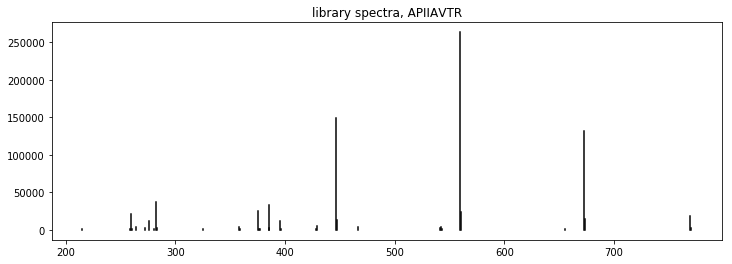

In [271]:

rcParams['figure.figsize'] = 12, 4
i=0
for x in libmzarray:
    plt.plot([x,x], [0, libintarray[i]], 'k')
    i=i+1
plt.title("library spectra, "+ SEQ)

### Function to get fragment ion masses from sequence

In [185]:
### cell to make tmpmzarray and tmpintarray for test of following functions 
# DELETE FROM SCRIPT VERSION #
i = 1
## check peptide # 1 and #10
with mzxml.read("P:/JGM_DI2A/SILAC/20190412_DI2A_1to1_tMS2_n3.mzXML") as tmpquantfile:
    #for x in quantscans: #loop throught the scans once this works using the part below by replacing the first list grab with x
    tmpmzarray = tmpquantfile.get_by_id(str(sortedpepdf['quantscans'].tolist()[i][0]))['m/z array']
    tmpintarray = tmpquantfile.get_by_id(str(sortedpepdf['quantscans'][i][0]))['intensity array']

In [186]:
# to extract the int values between two other values
def getFragMz(pred_mass, mz_array, int_array, ppm):
    ''' 
    PURPOSE:
    Find observed m/z value matching theoretical value in spectra
    
    INPUTS:
    pred_mass = the theoretical mass of the fragment ion
    mz_array = numpy array of all peak masses in the spectra
    int_array = numpy array of all peak intensities in the spectra
    ppm = the mass tolerance for the fragments in ppm
    
    OUTPUT:
    numpy array containing the value of the m/z found
    
    '''
    lowmz = pred_mass - pred_mass*ppm/1000000
    highmz = pred_mass + pred_mass*ppm/1000000
    found = np.extract([np.all([x>=lowmz, x<=highmz]) for x in mz_array], mz_array)
    if len(found)==0:
        found = [1]
    return(found[0])

## function test
st = time.time()
getFragMz(300.12, tmpmzarray, tmpintarray, 10)
print(str(time.time() - st)+'elapsed')

0.005986928939819336elapsed


In [187]:
mzlist = tmpmzarray.tolist()
intlist = tmpintarray.tolist()
[intlist[index] for index, value in enumerate(mzlist) if value>300 and value<300.12]

[366.0215759277344]

In [188]:
# to extract the int values between two other values
def getFragInt(pred_mass, mz_array, int_array, ppmpct, noiselevel):
    ''' 
    PURPOSE:
    Find observed intensity for theoretical m/z value in spectra
    
    INPUTS:
    pred_mass = the theoretical mass of the fragment ion
    mz_array = numpy array of all peak masses in the spectra
    int_array = numpy array of all peak intensities in the spectra
    ppm = the mass tolerance for the fragments in ppm
    noiselevel = value to be subtracted from each value
    
    OUTPUTS:
    numpy array containing the intensity for any m/z found
    
    '''
    
    lowmz = pred_mass - pred_mass*ppmpct
    highmz = pred_mass + pred_mass*ppmpct
    found = np.extract([np.all([x>=lowmz, x<=highmz]) for x in mz_array], int_array)
    found = [intlist[index] for index, value in enumerate(mzlist) if value>300 and value<300.12]
    #found = found-noiselevel
    if len(found)==0:
        found = [1]
    return(found[0])
    #return(highmz)

## function test
st = time.time()
tmptestint = getFragInt(300.12, tmpmzarray, tmpintarray, 1e-5,  250)
tmptestint = getFragInt(300.12, tmpmzarray, tmpintarray, 1e-5,  250)
tmptestint = getFragInt(300.12, tmpmzarray, tmpintarray, 1e-5,  250)
tmptestint = getFragInt(300.12, tmpmzarray, tmpintarray, 1e-5,  250)
tmptestint = getFragInt(300.12, tmpmzarray, tmpintarray, 1e-5,  250)
tmptestint = getFragInt(300.12, tmpmzarray, tmpintarray, 1e-5,  250)
tmptestint = getFragInt(300.12, tmpmzarray, tmpintarray, 1e-5,  250)
tmptestint = getFragInt(300.12, tmpmzarray, tmpintarray, 1e-5,  250)
tmptestint = getFragInt(300.12, tmpmzarray, tmpintarray, 1e-5,  250)
tmptestint = getFragInt(300.12, tmpmzarray, tmpintarray, 1e-5,  250)
(time.time() - st)/10

0.005986499786376953

In [189]:
# to extract the int values between two other values
def getFragInt(pred_mass, mz_list, int_list, ppmpct):
    ''' 
    PURPOSE:
    Find observed intensity for theoretical m/z value in spectra
    
    INPUTS:
    pred_mass = the theoretical mass of the fragment ion
    mz_array = numpy array of all peak masses in the spectra
    int_array = numpy array of all peak intensities in the spectra
    ppm = the mass tolerance for the fragments in ppm
    noiselevel = value to be subtracted from each value
    
    OUTPUTS:
    numpy array containing the intensity for any m/z found
    
    '''
    
    lowmz = pred_mass - pred_mass*ppmpct
    highmz = pred_mass + pred_mass*ppmpct
    found = [int_list[index] for index, value in enumerate(mz_list) if value>lowmz and value<highmz]
    #found = found-noiselevel
    if len(found)==0:
        found = [1]
    return(found[0])
    #return(highmz)

## function test
st = time.time()
tmptestint = getFragInt(300.12, tmpmzarray, tmpintarray, 5e-6)
tmptestint = getFragInt(300.12, tmpmzarray, tmpintarray, 1e-5)
tmptestint = getFragInt(300.12, tmpmzarray, tmpintarray, 1e-5)
tmptestint = getFragInt(300.12, tmpmzarray, tmpintarray, 1e-5)
tmptestint = getFragInt(300.12, tmpmzarray, tmpintarray, 1e-5)
tmptestint = getFragInt(300.12, tmpmzarray, tmpintarray, 1e-5)
tmptestint = getFragInt(300.12, tmpmzarray, tmpintarray, 1e-5)
tmptestint = getFragInt(300.12, tmpmzarray, tmpintarray, 1e-5)
tmptestint = getFragInt(300.12, tmpmzarray, tmpintarray, 1e-5)
tmptestint = getFragInt(300.12, tmpmzarray, tmpintarray, 1e-5)
(time.time() - st)/10

0.0017981529235839844

# Loop through files to quantify and extract fragment ion signals

In [272]:
#subset of without 16x
fileslist = ["P:/JGM_DI2A/SILAC/20190412_DI2A_1to8_tMS2_n1.mzXML",
             "P:/JGM_DI2A/SILAC/20190412_DI2A_1to8_tMS2_n2.mzXML",
             "P:/JGM_DI2A/SILAC/20190412_DI2A_1to8_tMS2_n3.mzXML",
             "P:/JGM_DI2A/SILAC/20190412_DI2A_1to4_tMS2_n1.mzXML",
             "P:/JGM_DI2A/SILAC/20190412_DI2A_1to4_tMS2_n2.mzXML",
             "P:/JGM_DI2A/SILAC/20190412_DI2A_1to4_tMS2_n3.mzXML",
             "P:/JGM_DI2A/SILAC/20190412_DI2A_1to2_tMS2_n1.mzXML",
             "P:/JGM_DI2A/SILAC/20190412_DI2A_1to2_tMS2_n2.mzXML",
             "P:/JGM_DI2A/SILAC/20190412_DI2A_1to2_tMS2_n3.mzXML",
             "P:/JGM_DI2A/SILAC/20190412_DI2A_1to1_tMS2_n1.mzXML",
             "P:/JGM_DI2A/SILAC/20190412_DI2A_1to1_tMS2_n2.mzXML",
             "P:/JGM_DI2A/SILAC/20190412_DI2A_1to1_tMS2_n3.mzXML",
             "P:/JGM_DI2A/SILAC/20190412_DI2A_2to1_tMS2_n1.mzXML",
             "P:/JGM_DI2A/SILAC/20190412_DI2A_2to1_tMS2_n2.mzXML",
             "P:/JGM_DI2A/SILAC/20190412_DI2A_2to1_tMS2_n3.mzXML",
             "P:/JGM_DI2A/SILAC/20190412_DI2A_4to1_tMS2_n1.mzXML",
             "P:/JGM_DI2A/SILAC/20190412_DI2A_4to1_tMS2_n2.mzXML",
             "P:/JGM_DI2A/SILAC/20190412_DI2A_4to1_tMS2_n3.mzXML",
             "P:/JGM_DI2A/SILAC/20190412_DI2A_8to1_tMS2_n1.mzXML",
             "P:/JGM_DI2A/SILAC/20190412_DI2A_8to1_tMS2_n2.mzXML",
             "P:/JGM_DI2A/SILAC/20190412_DI2A_8to1_tMS2_n3.mzXML"
            ]

In [273]:
speclib = mgf.read('P:/JGM_DI2A/MSPLIT-DIAv1.0/human.faims.fixed.decoy.mgf')

In [197]:
#fileslist[0:9]

In [205]:
## version that doesnt use noise
# pretty slow for some reason
resultsdict = {}
stt = time.time()
for k in fileslist:
    meanratio_list = []
    medianratio_list= []
    matchdf_list = []
    ppmpct = 10e-6
    with mzxml.read(k) as tmpquantfile:
        quantscans=sortedpepdf['quantscans'].tolist()
        peplist = sortedpepdf['Peptide'].tolist()
        specnamelist = sortedpepdf['Name'].tolist()
        looplen = len(sortedpepdf)
        st = time.time()
        for i in range(0, looplen):
            tmp_qf = getQuantFragsFromLib(peplist[i], specnamelist[i], speclib)
            tmpmzarray = tmpquantfile.get_by_id(str(quantscans[i][0]))['m/z array'].tolist()
            tmpintarray = tmpquantfile.get_by_id(str(quantscans[i][0]))['intensity array'].tolist()
            lightints = [getFragInt(x, tmpmzarray, tmpintarray, ppmpct) for x in tmp_qf['lightmz']]
            heavyints = [getFragInt(x, tmpmzarray, tmpintarray, ppmpct) for x in tmp_qf['heavymz']]
            #lightmzfound = [getFragMz(x, tmpmzarray, tmpintarray, ppm) for x in tmp_qf['lightmz']]
            #heavymzfound = [getFragMz(x, tmpmzarray, tmpintarray, ppm) for x in tmp_qf['heavymz']]
            ratios = [x/y for x,y in zip(heavyints, lightints)]
            #tmp_qf['lightmzfound'] = lightmzfound
            #tmp_qf['heavymzfound'] = heavymzfound
            tmp_qf['lightint'] = lightints
            tmp_qf['heavyint'] = heavyints
            tmp_qf['HLratios'] = ratios
            matchdf_list.append(tmp_qf)

            # remove values that are both zero, compute new ratios
            intsum = [sum(x) for x in zip(heavyints, lightints)]
            rm = [index for index, value in enumerate(intsum) if value==2] # get index of values that are both 1 
            for x in sorted(rm, reverse=True):
                del lightints[x]
                del heavyints[x]
            rm0ratios = [x/y for x,y in zip(heavyints, lightints)]

            # check if there are less than 3 ratios total, if so, set ratio to empty
            if len(lightints)<3:
                meanratio_list.append([])
                medianratio_list.append([])
            else:
                meanratio_list.append(np.mean(rm0ratios))
                medianratio_list.append(np.median(rm0ratios))
            #print('time for 1 spec= '+str(time.time()-sts))
        print('file= '+k+', quantified '+str(looplen/(time.time()-st))+' spectra per second')
    resultsdict[k] = [matchdf_list, medianratio_list, meanratio_list]
print(time.time()-stt)

file= P:/JGM_DI2A/SILAC/20190412_DI2A_1to8_tMS2_n1.mzXML, quantified 15.438966080034067 spectra per second
file= P:/JGM_DI2A/SILAC/20190412_DI2A_1to8_tMS2_n2.mzXML, quantified 15.373458883418003 spectra per second
file= P:/JGM_DI2A/SILAC/20190412_DI2A_1to8_tMS2_n3.mzXML, quantified 15.055197233353766 spectra per second
file= P:/JGM_DI2A/SILAC/20190412_DI2A_1to4_tMS2_n1.mzXML, quantified 14.482014488533915 spectra per second
file= P:/JGM_DI2A/SILAC/20190412_DI2A_1to4_tMS2_n2.mzXML, quantified 14.796323157187189 spectra per second
file= P:/JGM_DI2A/SILAC/20190412_DI2A_1to4_tMS2_n3.mzXML, quantified 14.942093773339824 spectra per second
file= P:/JGM_DI2A/SILAC/20190412_DI2A_1to2_tMS2_n1.mzXML, quantified 15.225169862069656 spectra per second
file= P:/JGM_DI2A/SILAC/20190412_DI2A_1to2_tMS2_n2.mzXML, quantified 15.04784101149457 spectra per second
file= P:/JGM_DI2A/SILAC/20190412_DI2A_1to2_tMS2_n3.mzXML, quantified 15.564244901658032 spectra per second
file= P:/JGM_DI2A/SILAC/20190412_DI2A_

### pickle the quant results to enable re-loading later

In [206]:
with open('results_10ppm_3libfrag_exlude16x.pkl', 'wb') as f:
    pickle.dump(resultsdict, f)

# Start here to reload the pickle results and skip Quant step

In [7]:
with open('results_10ppm_3libfrags.pkl', 'rb') as f:
    resultsdict = pickle.load(f)

In [274]:
resultsdict['P:/JGM_DI2A/SILAC/20190412_DI2A_1to8_tMS2_n1.mzXML'][0][3]
#==testrd1['P:/JGM_DI2A/SILAC/20190412_DI2A_1to16_tMS2_n1.mzXML']

,fragseq,lightmz,heavymz,lightint,heavyint,HLratios
4,DTSSEITTK,981.473496,989.487695,15145.867188,1849.950195,0.122142
3,VDTSSEITTK,1080.541910,1088.556109,8882.348633,954.845276,0.107499
10,TTK,349.208161,357.222360,4377.587891,450.101593,0.102820


## Plot the median values

### Plot the boxplots for all replicates

In [275]:
allmedians = []
allmeans = []
for x in fileslist:
    tmpmedians = resultsdict[x][1]
    tmpmeans = resultsdict[x][2]
    allmedians.append([np.log2(x) for x in tmpmedians if type(x) != list ])
    allmeans.append([np.log2(x) for x in tmpmeans if type(x) != list ])

In [276]:
i=1
xvals = []
for x in allmedians:
    xvals = xvals +[i]*len(x)
    i+=1

In [279]:
### How many peptides were quantified in each run?
[len(x) for x in allmedians]

[1419,
 1417,
 1457,
 1404,
 1430,
 1417,
 1365,
 1375,
 1305,
 1315,
 1342,
 1333,
 1316,
 1315,
 1270,
 1296,
 1293,
 1278,
 1219,
 1209,
 1207]

In [213]:
from pylab import rcParams
rcParams['figure.figsize'] = 7, 4

### Convert the multiple lists into one long list in order to generate heatmap

In [280]:
allmedianslonglist = []
allmeanslonglist = []
for x in fileslist:
    tmpmedians = resultsdict[x][1]
    tmpmeans = resultsdict[x][2]
    #tmpval[np.log2(y) for y in tmpmedians if type(y) != list ] 
    allmedianslonglist = allmedianslonglist + [np.log2(y) for y in tmpmedians if type(y) != list ]
    allmeanslonglist = allmeanslonglist + [np.log2(y) for y in tmpmeans if type(y) != list ]

## Make panel B of figure 3

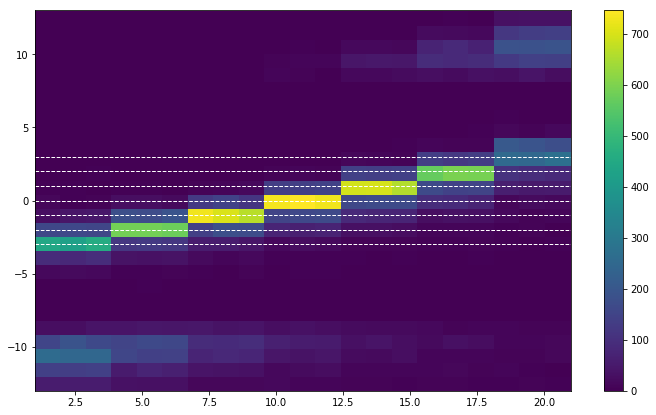

In [282]:
rcParams['figure.figsize'] = 12, 7
fig, ax = plt.subplots()
h = ax.hist2d(np.array(xvals), np.asarray(allmedianslonglist), bins=[21,32], )
plt.ylim(-13,13)
plt.colorbar(h[3], ax=ax)

#tmp2dhist = plt.hist2d()
#plt.plot([1, 27], [np.log2(1/16), np.log2(1/16)], color='w', linestyle='--', linewidth=1)
plt.plot([1, 27], [np.log2(1/8), np.log2(1/8)], color='w', linestyle='--', linewidth=1)
plt.plot([1, 27], [np.log2(1/4), np.log2(1/4)], color='w', linestyle='--', linewidth=1)
plt.plot([1, 27], [np.log2(1/2), np.log2(1/2)], color='w', linestyle='--', linewidth=1)
plt.plot([1, 27], [np.log2(1/1), np.log2(1/1)], color='w', linestyle='--', linewidth=1)
plt.plot([1, 27], [np.log2(2/1), np.log2(2/1)], color='w', linestyle='--', linewidth=1)
plt.plot([1, 27], [np.log2(4/1), np.log2(4/1)], color='w', linestyle='--', linewidth=1)
plt.plot([1, 27], [np.log2(8/1), np.log2(8/1)], color='w', linestyle='--', linewidth=1)
#plt.plot([1, 27], [np.log2(16/1), np.log2(16/1)], color='w', linestyle='--', linewidth=1)
#plt.savefig('P:/JGM_DI2A/Python/outputs/top3frags_medianHM_32_exclude16x.svg', format='svg')

## Make panel A of figure 3 from nLC-MSMS peptide quantification by MQ

In [77]:
lc = pd.read_csv("P:/JGM_DI2A/20190411_SILAC_LC/MQpeptides_Quant.txt", sep="\t")

In [81]:
lc.head()

,Sequence,N-term cleavage window,C-term cleavage window,Amino acid before,First amino acid,Second amino acid,Second last amino acid,Last amino acid,Amino acid after,A Count,...,Reverse,Potential contaminant,id,Protein group IDs,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,MS/MS Count
0,AAAAAAAAVPSAGPAGPAPTSAAGR,SPASVSAPKQILQPRAAAAAAAAVPSAGPA,SAGPAGPAPTSAAGRTFPASGGGYKASSPA,R,A,A,G,R,T,13,...,NaN,NaN,0,3527,0,0,0,0,NaN,1
1,ECCDKPLLEK,KYICDNQDTISSKLKECCDKPLLEKSHCIA,SSKLKECCDKPLLEKSHCIAEVEKDAIPEN,K,E,C,E,K,S,0,...,NaN,+,4203,13,4258,36188;36189;36190;36191;36192;36193;36194;3619...,48405;48406;48407;48408;48409;48410;48411;4841...,48409,NaN,11
2,RAAVGRPLDK,QAQYCRAAEELSKLRRAAVGRPLDKHEGAL,LSKLRRAAVGRPLDKHEGALETLLRYYDQI,R,R,A,D,K,H,2,...,NaN,NaN,18523,2500,18802,159466,211983,211983,NaN,1
3,AAAAADLANR,YLGFGTPSNLGKGRRAAAAADLANRSGESN,GKGRRAAAAADLANRSGESNTHQDIEEKDR,R,A,A,N,R,S,6,...,NaN,NaN,3,458,3,30,48,48,NaN,1
4,LVALNLDR,QLGSYDPLPNSHGEKLVALNLDRIRHWIGC,PNSHGEKLVALNLDRIRHWIGCGAHLSKPM,K,L,V,D,R,I,1,...,NaN,NaN,14769,3505,14958,128112,170548,170548,NaN,1


In [284]:
allfc = []
allfc.append(lc["Ratio H/L 1to8"][lc["Ratio H/L 1to8"].notnull()])
allfc.append(lc["Ratio H/L 1to4"][lc["Ratio H/L 1to4"].notnull()])
allfc.append(lc["Ratio H/L 1to2"][lc["Ratio H/L 1to2"].notnull()])
allfc.append(lc["Ratio H/L 1to1"][lc["Ratio H/L 1to1"].notnull()])
allfc.append(lc["Ratio H/L 2to1"][lc["Ratio H/L 2to1"].notnull()])
allfc.append(lc["Ratio H/L 4to1"][lc["Ratio H/L 4to1"].notnull()])
allfc.append(lc["Ratio H/L 8to1"][lc["Ratio H/L 8to1"].notnull()])
print(len(allfc))
print(len(allratioslc))

7

In [229]:
i=1
xvals2 = []
for x in allfc:
    print(len(x))
    xvals2 = xvals2 +[i]*len(x)
    i+=1

7841
11001
13243
14536
13454
7966
6855


## Make panel A of figure 3

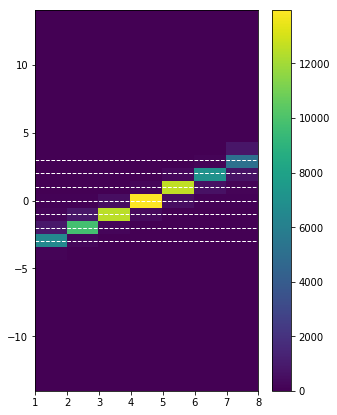

In [233]:
rcParams['figure.figsize'] = 5, 7
fig, ax = plt.subplots()
h = ax.hist2d(np.array(xvals2), np.asarray(np.log2(allratioslc)), bins=[7,31], range=[[1,8],[-15,15]])
plt.ylim(-14,14)
plt.colorbar(h[3], ax=ax)

#tmp2dhist = plt.hist2d()
#plt.plot([1, 27], [np.log2(1/16), np.log2(1/16)], color='w', linestyle='--', linewidth=1)
plt.plot([1, 27], [np.log2(1/8), np.log2(1/8)], color='w', linestyle='--', linewidth=1)
plt.plot([1, 27], [np.log2(1/4), np.log2(1/4)], color='w', linestyle='--', linewidth=1)
plt.plot([1, 27], [np.log2(1/2), np.log2(1/2)], color='w', linestyle='--', linewidth=1)
plt.plot([1, 27], [np.log2(1/1), np.log2(1/1)], color='w', linestyle='--', linewidth=1)
plt.plot([1, 27], [np.log2(2/1), np.log2(2/1)], color='w', linestyle='--', linewidth=1)
plt.plot([1, 27], [np.log2(4/1), np.log2(4/1)], color='w', linestyle='--', linewidth=1)
plt.plot([1, 27], [np.log2(8/1), np.log2(8/1)], color='w', linestyle='--', linewidth=1)
#plt.plot([1, 27], [np.log2(16/1), np.log2(16/1)], color='w', linestyle='--', linewidth=1)
plt.savefig('P:/JGM_DI2A/Python/outputs/top3frags_medianHM_31_lc_ex16.svg', format='svg')

# Targeted Quantification of the